# Musx-images : Image Triads

In [19]:
%reload_ext autoreload
%autoreload 2

import musx

# Loading a file from one directory up
import sys
sys.path.insert(0, '..') 
import musx_images

## Importing images
In order to start playing with musx-images, the first step is loading in an image. This is accomplished with `load_image(path)`. By default the image is parsed as an 8-bit RGB image, but a different color space can be specified with the optional `color_space` argument. A list of valid color spaces can be found under the variable `valid_color_spaces`. Note that grayscale is unique in that it is a single channel, unlike all other color spaces that are three channels.

An image can be printed with `display_image(image)` (or multiple images with `display_images(image_list)`), which has an optional argument `grayscale` to specify if you are printing a grayscale image.

Supported list of color spaces: BGR, Gray, HLS, HLS_FULL, HSV, HSV_FULL, Lab, Luv, RGB, XYZ, YCbCr, YUV


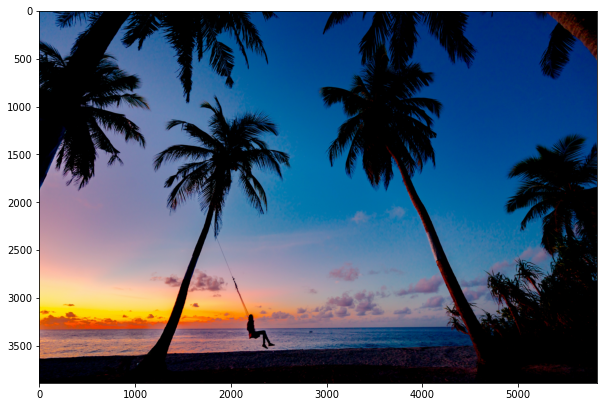

In [2]:
image = musx_images.load_image("../images/sunset_swing.jpg")
print("Supported list of color spaces: {}".format(', '.join(musx_images.valid_color_spaces)))
musx_images.display_image(image)

## Resizing images
Images can be shrunk using the `shrink_image(image, factor)` function. Images can be enlarged using the `enlarge_image(image, factor)` function. For either you can optionally specify an interpolation function with the optional `interpolation_mode` argument. A list of valid interpolation modes can be found under the variable `valid_interpolations`.

Supported list of interpolations: INTER_NEAREST, INTER_LINEAR, INTER_CUBIC, INTER_AREA, INTER_LINEAR_EXACT, INTER_NEAREST_EXACT, INTER_MAX


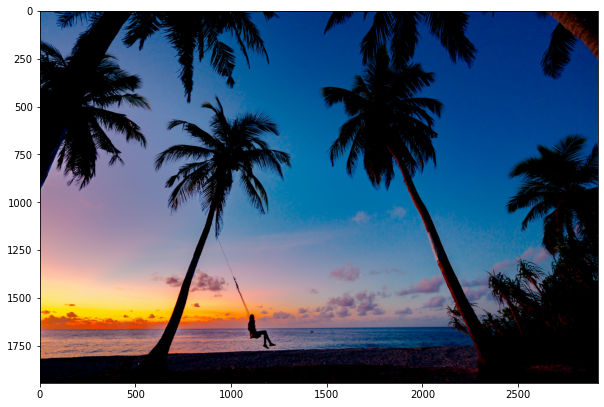

In [3]:
print("Supported list of interpolations: {}".format(', '.join(musx_images.valid_interpolations)))
shrunk = musx_images.shrink_image(image, 0.5)
musx_images.display_image(shrunk)

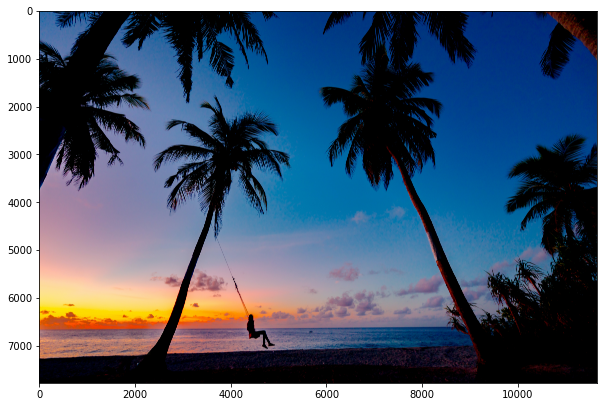

In [4]:
enlarged = musx_images.enlarge_image(image, 2)
musx_images.display_image(enlarged)

## Blurring images
Images can be shrunk using the `blur_image(img, intensity)` function. This blurring is accomplished by shrinking the image and then enlarging the shrunk image. Depending on the size of your image, you may need to crank the `intensity` value up quite high to see a result. Both resize interpolations can be specified under `shrink_interp_mode` and `enlarge_interp_mode` respectively.

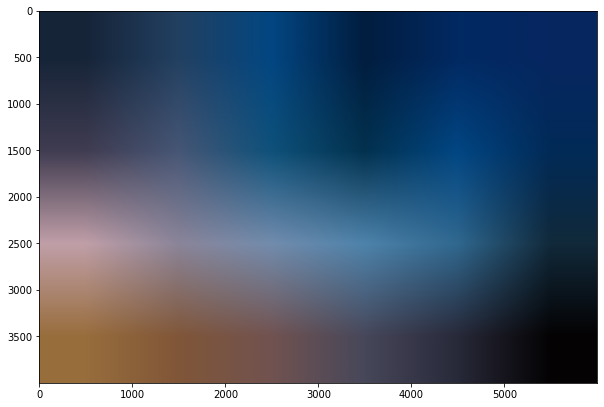

In [5]:
blurred_image = musx_images.blur_image(image, 1000)
musx_images.display_image(blurred_image)

## 2D Generators
In order to sonify images, we need to extract information from the images as well as have some way to grab pixels from the image. To solve this, musx-images has a set of 2D generators to traverse over 2D arrays. Each generator outputs a pair in the form `(data, (dim1_index, dim2_index))`. In the case of images, `data` will be a triple containing information from each color channel. Below in the `image_triads()` composer, `random_2d(items)` is used to randomly pull pixels from an image in data form that is passed in.

Something really interesting about the 2D generators is that they are not limited to images- they should work with any data that is at least 2-dimensional!

In [6]:
def image_triads(queue, chan, image, notes, length, rhy):
    random_gen = musx_images.random_2d(image)
    rhythms = musx.choose([0, rhy/4, rhy/2, [0, rhy/2], [0, rhy/4, rhy/2, 3 * (rhy/4)], [0, 3 * (rhy/4)]])

    for _ in range(length):
        triad_raw, location = next(random_gen)
        points.append(location)
        
        triad = map(lambda x : notes[round(musx.rescale(x, 0, 255, 0, len(notes) - 1))], triad_raw)
        for note_num in triad:
            r = next(rhythms)
            if musx.isnum(r):
                queue.out.addevent(musx.MidiNote(time=queue.now, dur=rhy - r, key=note_num, chan=chan))
            else:
                deltas = musx.deltas(r + [rhy])
                for ind, time in enumerate(r):
                    queue.out.addevent(musx.MidiNote(time=queue.now + time, dur=deltas[ind], key=note_num, chan=chan))
        yield rhy


## Generating a MIDI file with musx

This is standard musx procedure for generating a MIDI file.

In [20]:
points = []

t0 = musx.MidiSeq.metaseq(ins={})
t1 = musx.MidiSeq()

queue = musx.Scheduler(out=t1)

musx_images.clear_points_cache() # See cell below this for why this here

queue.compose([
    [0, image_triads(queue, 0, blurred_image, musx.scale(48, 31, 2, 2, 1, 2, 2, 2, 1), 100, 1)]
])

musx.MidiFile("image_triads.mid", [t0, t1]).write()

Done!


<MidiFile: 'image_triads.mid' 0x7fcc732e39a0>

## Plotting selected elements
For the 2D generators, musx-images yields the data alongside the indices of where that data is. Musx-images also has a variable that tracks the points from any used 2D generators: `points_cache`. Note that you will need to manually clear `points_cache` otherwise the list will persist between 2D generator calls. For images in particular it can be interesting to see what pixels were selected. For that, `points_image(image, points)` can be used to generate an image with the selected pixels. If they are difficult to see, change `enlarge` to make the pixels larger; by default it is set to 25, making each pixel plotted as a 50x50 square.

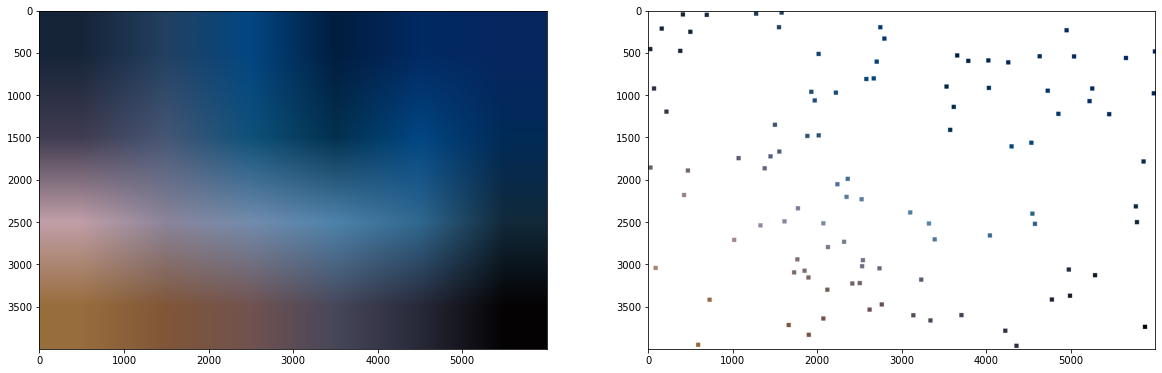

In [18]:
points_image = musx_images.points_image(blurred_image, musx_images.points_cache)
musx_images.display_images([blurred_image, points_image])